In [89]:
import arviz as az
import numpy as np  # For vectorized math operations

# import pandas as pd  # For file input/output
import pymc as pm
import pytensor.tensor as pt
from scipy.stats import gumbel_r

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
plt.rcParams["font.family"] = "Latin Modern Roman"

rng = np.random.default_rng(42)

# Simulate some data

Data generating process is:
$$
u_{ij} = {x_i}'\beta^{\text{individual}}_{i} + {c_j}'\beta^{\text{product}}_{i} + \eta_{ij} - \eta_{i0}
$$
where
- the consumer knows $\left(x_i, \beta^{\text{individual}}_i, c_j, \beta^{\text{product}}_{i}, \eta_{ij}\right)$, which implies outcome variables $\left(t_i, w_i\right)$
- the econometrician knows $\left(x_i, c_j, t_i, w_i\right)$ and has priors over $\left(\beta^{\text{individual}}, \beta^{\text{product}}\right)$
- neither the consumer nor the econometrician knows $\eta_{i0}$, but they have common priors

Consumer reports
- their preferred good $j^{(1)}$
- the probability they purchase the good on a Likert scale with $W$ categories

## Notation

- $N$ is the number of individuals
- $J$ is the number of products
- $K$ is the number of product attributes
- $M$ is the number of individual attributes
- $W$ is the number of categories on the Likert scale

In [101]:
def make_data(params=None, likert=False, individual=False):

    ## set default parameters
    if params is None:
        params = {"N": 1000, "J": 3, "K": 2, "M": 2, "W": 4}

    ## load parameters
    M = params["M"]
    W = params["W"]
    J = params["J"]
    K = params["K"]
    N = params["N"]

    np.random.seed(1234)

    ## generate latent parameters
    
    # individual_features = np.random.normal(0, 0.1, (N, M))
    individual_features = np.zeros((N, M))
    β_ind = np.random.normal(0, 1, M)
    
    product_features = np.random.normal(0, 0.2, (J, K))
    # β_prod = np.random.normal(0, 0.2, (K, N))
    β_prod = np.repeat([[-1],[1]], N, axis=1)
    
    # ν = np.random.normal(0, 1, (N, J))
    η = np.random.gumbel(0, 1, (N, J))
    # ɛ = np.random.normal(0, 1, (N, J))

    ## generate data
    # y = np.zeros((N, J))
    u_individual = np.outer(
        individual_features @ β_ind,
        np.ones(J),
    )
    u_product = (product_features @ β_prod).T

    u = u_product + η
    if individual:
        u += u_individual
        # with constant individual effects, the individual features do nothing
        
    t = np.argmax(u, axis=1)
    v = np.max(u, axis=1)

    if likert:
        π = np.random.dirichlet([1] * W, 1).flatten().cumsum()
        w = np.digitize(gumbel_r.cdf(v), π)
    else:
        η0 = np.random.gumbel(0, 1, N)
        w = v > η0

    data = {
        "individual_features": individual_features,
        "product_features": product_features,
        "t": t,
        "w": w,
        "latent_utilities": u-η,
        "taste_shocks": η,
        "β_prod": β_prod
    }

    if likert:
        data["latent_cutpoints"] = π
    
    return data


df = make_data()

First, try "classical" conjoint, in which $\eta_0$ is observed by the consumer.

In [104]:
def gumbel_pdf(x, mu=0, beta=1):
    z = (x - mu)/beta
    return np.exp(-(z + np.exp(-z)))

def gumbel_cdf(x, mu=0, beta=1):
    z = (x - mu)/beta
    return np.exp(-np.exp(-z))

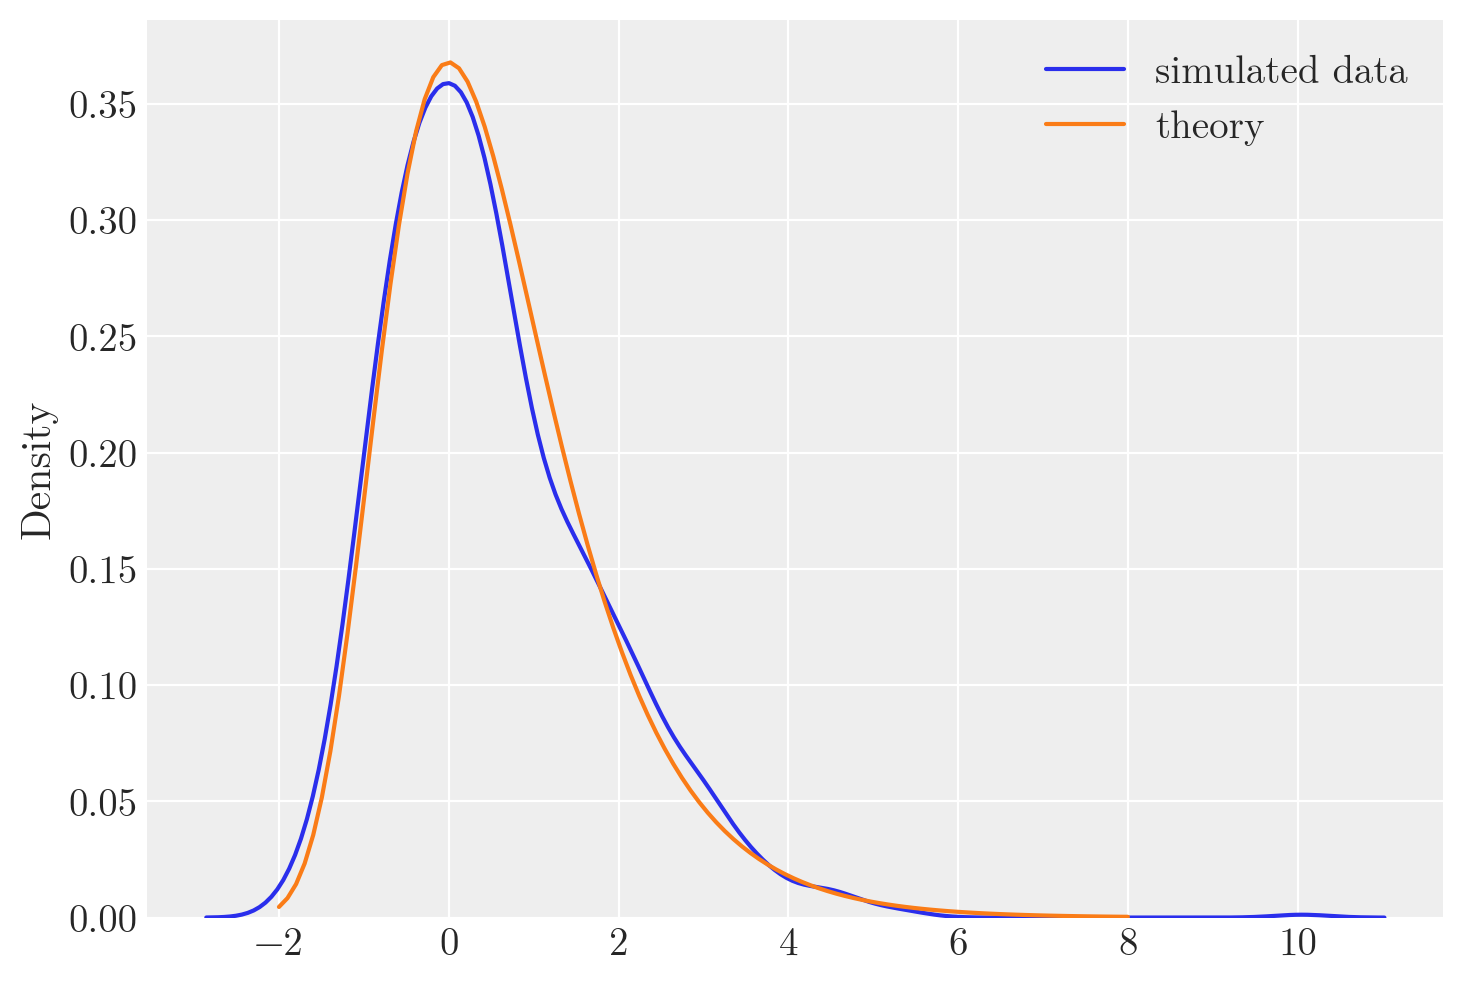

In [102]:
fig, ax = plt.subplots()
sns.kdeplot(df["taste_shocks"][:, 0], ax=ax, label="simulated data")
sns.lineplot(x=np.linspace(-2, 8, 100), y=[gumbel_pdf(x) for x in np.linspace(-2, 8, 100)], ax=ax, label="theory")
plt.show()

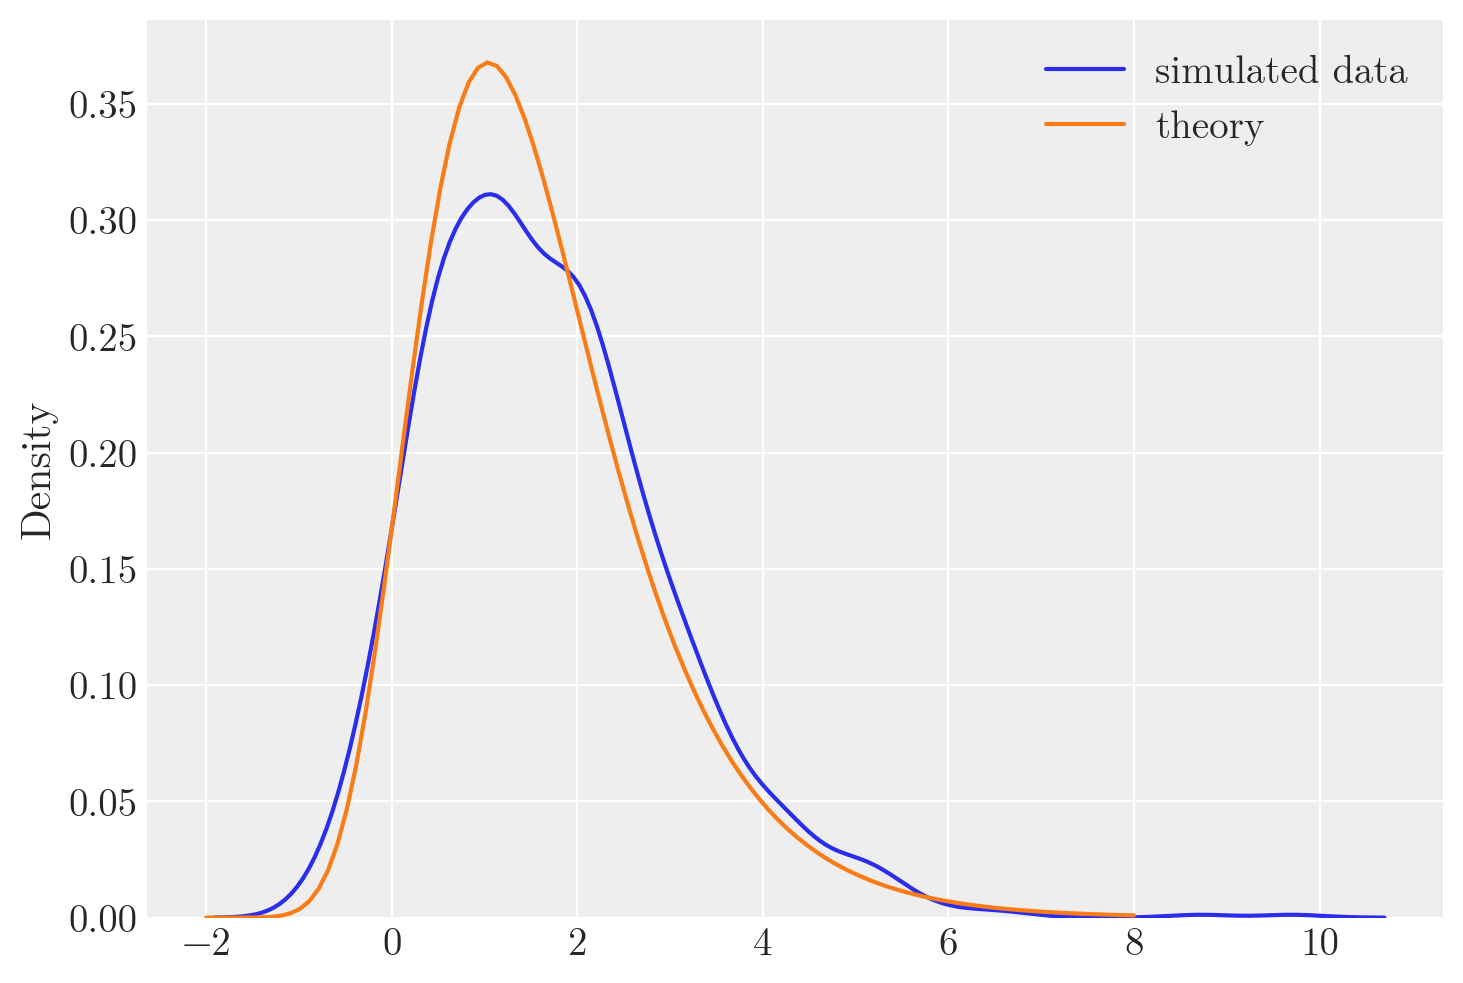

In [103]:
fig, ax = plt.subplots()
mu_bar = np.log(np.exp(df["latent_utilities"][0, 0])+np.exp(df["latent_utilities"][0, 1])+np.exp(df["latent_utilities"][0, 2]))
sns.kdeplot(np.max(df["latent_utilities"] + df["taste_shocks"], axis=1), ax=ax, label="simulated data")
sns.lineplot(x=np.linspace(-2, 8, 100), y=[gumbel_pdf(x, mu_bar) for x in np.linspace(-2, 8, 100)], ax=ax, label="theory")
plt.show()

0.7386305224918723

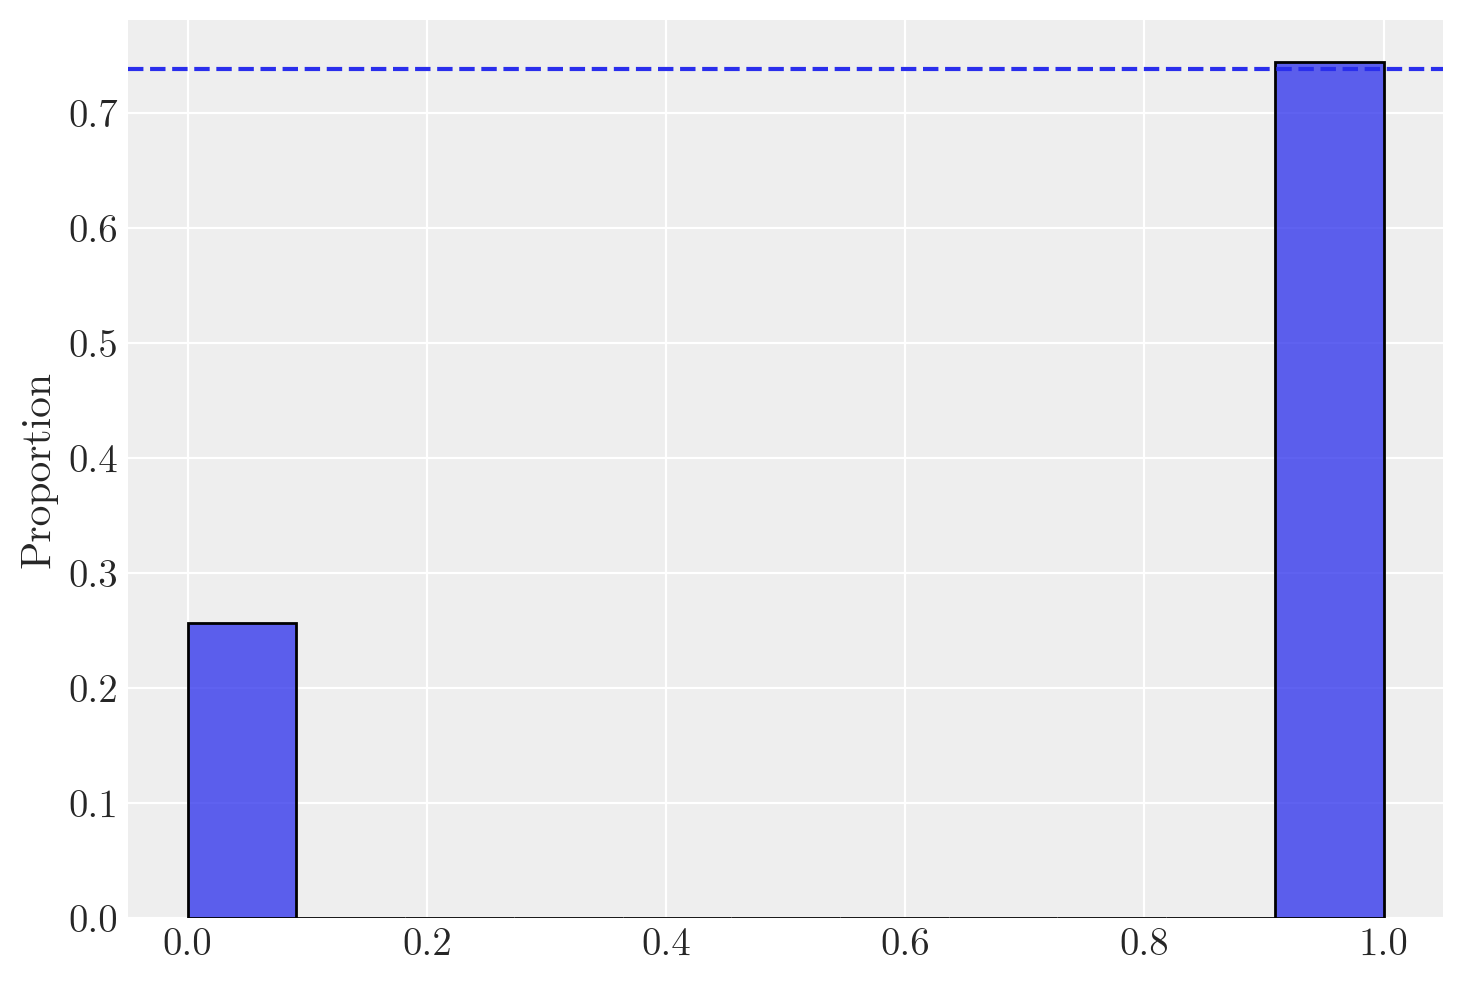

In [127]:
fig, ax = plt.subplots()
sns.histplot(df["w"], stat="proportion", ax=ax)
ax.axhline(1/(1+np.exp(-mu_bar)), ls ="--")
plt.show()

# Estimate the Model

In [128]:
observed_good = df["t"]
observed_bin = df["w"]

N, M = df["individual_features"].shape
J, K = df["product_features"].shape
W = len(np.unique(observed_bin))


coords = {
    "products": [f"product_{i}" for i in range(J)],
    "i_factors": [f"if_{i}" for i in range(N)],
    "p_factors": [f"pf_{i}" for i in range(K)],
    "obs": range(N),
}

In [134]:
with pm.Model(coords=coords) as model_1:

    beta_p = pm.math.stack(
        [
            [
                pm.Normal(
                    f"beta_p{i}",
                    pm.Normal(f"mu_β_p{i}", 0, 1),
                    pm.Exponential(f"sigma_β_p{i}", 1),
                )
                for i in range(K)
            ]
        ]
    ) # 1 * K

    beta = pm.math.dot(pm.math.ones((N, 1)), beta_p) # N * K

    ## Construct Utility matrix

    h_good = pm.math.dot(beta, df["product_features"].T)  # N x J

    h = h_good + 0

    ## Calculate good conditional likelihoods
    p_goods = pm.Deterministic(
        "p_good",
        pm.math.softmax(h, axis=1)
    ) # probability that good i is best of J

    # v = pm.math.max(h, axis=1)
    mu_bar = pm.math.log(pm.math.sum(pm.math.exp(h), axis=1)) # N * 1
    
    p_buy = pm.Deterministic(
        "p_buy", 1 / (1 + pm.math.exp(-mu_bar))
    ) # probability that good i is better than outside good

    ## Map to observables
    good_obs = pm.Categorical("product", p=p_goods, observed=observed_good, dims="obs")
    buy_obs = pm.Bernoulli("buy", p=p_buy, observed=observed_bin, dims="obs")

    idata_m1 = pm.sample_prior_predictive()
    idata_m1.extend(
        pm.sample(
            nuts_sampler="numpyro",
            idata_kwargs={"log_likelihood": True},
            random_seed=100,
        )
    )
    idata_m1.extend(pm.sample_posterior_predictive(idata_m1))

Sampling: [beta_p0, beta_p1, buy, mu_β_p0, mu_β_p1, product, sigma_β_p0, sigma_β_p1]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There were 450 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [buy, product]


Output()

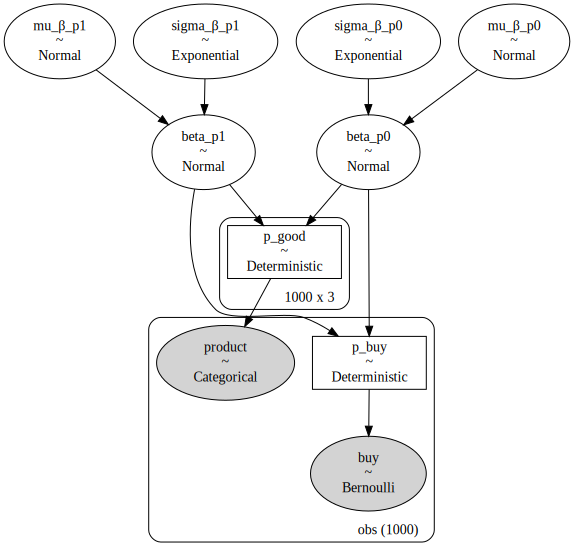

In [ ]:
pm.model_to_graphviz(model_1)

In [ ]:
az.summary(idata_m1, var_names=["mu_β_p0", "mu_β_p1", "sigma_β_p0", "sigma_β_p1"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_β_p0,-0.854,0.773,-2.185,0.569,0.040,0.042,270.0,171.0,1.02
mu_β_p1,0.361,0.662,-0.813,1.650,0.033,0.024,409.0,1318.0,1.01
sigma_β_p0,0.921,0.863,0.039,2.572,0.039,0.027,148.0,103.0,1.03
sigma_β_p1,0.750,0.740,0.021,2.028,0.070,0.049,31.0,12.0,1.09


# Things below are for the Likert Dual Response Model - Work in Progress

In [ ]:
with pm.Model(coords=coords) as model_1:

    mu_β_p = pm.Normal("mu_β_p", 0, 1)
    sigma_β_p = pm.Exponential("sigma_β_p", 1)
    beta_p = pm.Normal(
        "beta_pf", mu_β_p, sigma_β_p, dims=["obs", "p_factors"]
    )  # want there to be N*K beta's

    π = pm.Dirichlet("latent_binwidths", a=np.ones(W))  # W x 1
    α = pm.Deterministic(
        "latent_cutpoints", pt.concatenate([np.ones(1) * 0, pt.extra_ops.cumsum(π)])
    )  # (W+1) x 1

    ## Construct Utility matrix

    s_good = pm.math.dot(beta_p, df["product_features"].T)  # N x J
    # individual_effects = pm.math.sum(pm.math.dot(beta_i, df["individual_features"]), axis=1)
    # s_person = individual_effects[:, None] * pm.math.ones_like(df["individual_features"])
    s = s_good + 0

    ## Calculate good conditional likelihoods
    p_goods = pm.math.softmax(s, axis=1)  # probability that good i is best of J

    ## Apply Gumbel-Max Adjustment
    μbar = pm.math.log(pm.math.sum(pm.math.exp(s), axis=1))  # should be N x 1

    sandwich_meat = [
        (
            pm.math.exp(pm.math.exp(μbar) * pm.math.log(α[w]))
            - pm.math.exp(pm.math.exp(μbar) * pm.math.log(α[w - 1]))
        )
        for w in range(2, W)
    ]

    ## Calculate bin conditional likelihoods
    p_bins = pt.stack(
        [
            pm.math.exp(pm.math.exp(μbar) * pm.math.log(α[1])),  # should be N x 1
            *sandwich_meat,  # should be N x W-2
            1 - pm.math.exp(pm.math.exp(μbar) * pm.math.log(α[-1])),  # should be N x 1
        ],
        axis=0,
    ).T  # should be N x W

    ## Map to observables
    good_obs = pm.Categorical("product", p=p_goods, observed=observed_good, dims="obs")
    # prob_obs = pm.Categorical("bin", p=probs, observed=observed_prob, dims="obs")
    bin_obs = pm.Categorical("bin", p=p_bins, observed=observed_bin, dims="obs")

    idata_m1 = pm.sample_prior_predictive()
    idata_m1.extend(
        pm.sample(
            nuts_sampler="numpyro",
            idata_kwargs={"log_likelihood": True},
            random_seed=100,
        )
    )
    idata_m1.extend(pm.sample_posterior_predictive(idata_m1))

pm.model_to_graphviz(model_1)

In [ ]:
az.summary(idata_m1, var_names=["mu_β_p", "sigma_β_p", "latent_cutpoints"])